In [1]:
import pandas_datareader.data as web
import pandas as pd
from datetime import date
import yahoo_fin.stock_info as si
from yahoo_fin.stock_info import get_data
import numpy as np
import math
import time
from yahoofinancials import YahooFinancials
from scipy import stats
from statistics import mean
from scipy.stats import percentileofscore
from datetime import datetime, timedelta
import pandas_market_calendars as mcal
from decimal import Decimal
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
from plotly.offline import iplot
import plotly.express as px
from plotly.subplots import make_subplots
import pickle
import yfinance as yf
from matplotlib.pyplot import figure
import robin_stocks as rs
import mplfinance as mpf
import matplotlib.patches as mpatches
import ipywidgets as widgets
from IPython.display import display

# Getting sector and market cap from robin:
1. Using yahoo_fin.stock_info to get the list of all tickers in SP500
2. Using robin_stocks to match each ticker with its sector

In [4]:
sp_list = si.tickers_sp500()
sp_list = [x for x in sp_list if x != 'CXO']
ll = []
for tick in sp_list:
    sector = rs.stocks.get_fundamentals(tick, info='sector')
    market_cap = rs.stocks.get_fundamentals(tick, info='market_cap')
    ll.append([tick, sector, market_cap])
col = ['Ticker', 'Sector', 'Market Cap']    
df_sector = pd.DataFrame(ll, columns=col)
df_sector['Sector'] = df_sector['Sector'].str[0]
df_sector['Market Cap'] = df_sector['Market Cap'].str[0]
df_sector['Market Cap'] = df_sector['Market Cap'].astype(float)
df_sector = df_sector.set_index('Ticker')
df_sector['Weight'] = 'N/A'

# Assigning weights to each company in its sector

In [5]:
for i in df_sector['Sector'].unique().tolist():
    total_sector_cap = df_sector[df_sector['Sector'] == i]['Market Cap'].sum()
    for ii in df_sector[df_sector['Sector'] == i].index.tolist():
        df_sector.loc[ii, 'Weight'] = df_sector.loc[ii, 'Market Cap'] / total_sector_cap        
df_sector.head()

,Sector,Market Cap,Weight
Ticker,,,
A,Health Technology,3.676362e+10,0.0105248
AAL,Transportation,1.110287e+10,0.0177007
AAP,Retail Trade,1.032378e+10,0.00318735
AAPL,Electronic Technology,2.234439e+12,0.454762
ABBV,Health Technology,1.866824e+11,0.0534439


# Loading prices for each ticker in S&P500:
for the last 5 years using robin_stocks

In [6]:
sp_list = si.tickers_sp500()
#CXO is not a valid member of SP500, getting rid of it:
sp_list = [x for x in sp_list if x != 'CXO']
l = []
for tick in sp_list:
    data = rs.stocks.get_stock_historicals(tick, interval="day", span="5year")
    df_data = pd.DataFrame(data)
    df_data = df_data.set_index('begins_at')
    df_data = df_data[['close_price', 'volume']]
    df_data = df_data.add_suffix(f'_{tick}')
    l.append(df_data)
final = pd.concat(l, axis=1)   
final.index = pd.to_datetime(final.index)
new_format = "%Y-%m-%d"
final.index = final.index.strftime(new_format)
final = final.dropna()
final = final.sort_index()

In [7]:
final.head()

,close_price_A,volume_A,close_price_AAL,volume_AAL,close_price_AAP,volume_AAP,close_price_AAPL,volume_AAPL,close_price_ABBV,volume_ABBV,...,close_price_YUM,volume_YUM,close_price_ZBH,volume_ZBH,close_price_ZBRA,volume_ZBRA,close_price_ZION,volume_ZION,close_price_ZTS,volume_ZTS
2016-02-04,37.420000,2833492.0,38.210000,8599627.0,147.850000,1573505.0,24.150000,185886608.0,56.760000,10351220.0,...,50.512078,17638480.0,97.550000,1561932.0,61.010000,864605.0,22.050000,5028633.0,41.540000,3949771.0
2016-02-05,36.040000,4424609.0,36.750000,10072744.0,143.940000,1284245.0,23.505000,185672256.0,53.120000,13263242.0,...,48.730778,11173493.0,95.010000,3952411.0,57.380000,877571.0,21.630000,3199305.0,40.910000,4058061.0
2016-02-08,34.800000,3888601.0,35.550000,12821858.0,141.450000,2109895.0,23.752500,216085500.0,52.890000,9369377.0,...,47.103159,7188275.0,92.030000,2825845.0,54.440000,728786.0,20.720000,4836154.0,40.190000,4314301.0
2016-02-09,35.370000,3464464.0,36.190000,11143254.0,141.500000,1239814.0,23.747500,177324780.0,53.480000,7655796.0,...,46.432552,6455415.0,91.900000,1750579.0,54.680000,662575.0,20.770000,4782764.0,39.860000,6277573.0
2016-02-10,35.850000,3169951.0,37.120000,8114127.0,138.570000,2203727.0,23.567500,169374404.0,52.720000,9302768.0,...,46.635131,3601678.0,92.910000,1279105.0,57.800000,890252.0,20.740000,4048528.0,39.330000,6629167.0


### We'll keep only price data and change column names to tickers

In [8]:
price = final.filter(like='close_price_')
ii = sp_list
price = price.rename(columns={f'close_price_{i}': i for i in ii})
price[ii] = price[ii].astype(float)
#returns = price.pct_change()
#returns
price.tail()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
2021-01-28,121.56,18.10,153.34,137.09,104.21,106.90,355.13,120.39,249.34,465.67,...,133.57,46.06,55.34,21.22,99.09,102.53,157.03,393.03,45.17,156.53
2021-01-29,120.17,17.17,149.14,131.96,102.48,104.20,348.25,123.59,241.92,458.77,...,130.57,44.84,53.49,21.03,96.59,101.49,153.67,387.83,44.14,154.25
2021-02-01,120.83,16.84,150.97,134.14,102.30,106.89,341.86,122.54,247.57,470.00,...,135.31,44.92,53.92,22.59,97.14,103.06,153.90,397.33,44.70,155.58
2021-02-02,123.19,16.59,154.08,134.99,103.47,105.62,347.84,120.24,248.75,484.93,...,137.31,45.63,54.56,22.85,97.18,106.30,158.50,405.19,45.80,157.39
2021-02-03,122.15,17.60,155.28,133.94,106.95,105.53,326.23,120.22,248.37,481.92,...,135.39,47.42,54.64,23.57,95.12,104.73,158.56,403.69,46.03,155.23


# Sector prices
In order to get prices for each sector we multiply each ticker price by its weight and sum the result for each ticker in sector list

In [9]:
#Multiplying ticker price by its weight:
price_weighted = price.copy()
all_sectors = df_sector['Sector'].tolist()
for sect in set(all_sectors):
    in_sector = df_sector[df_sector['Sector'] == sect].index.tolist()
    for i in in_sector:
        price_weighted[i] = price_weighted[i] * df_sector.loc[i, 'Weight']

#Getting sum of each weighted price to come to sector price
price_sector = pd.DataFrame()
for sect in set(all_sectors):
    in_sector = df_sector[df_sector['Sector'] == sect].index.tolist()
    price_sector[sect] = (price_weighted[[i for i in in_sector]]).sum(axis=1)

In [10]:
price_sector.head()

,Utilities,Energy Minerals,Consumer Services,Producer Manufacturing,Industrial Services,Process Industries,Consumer Durables,Non-Energy Minerals,Consumer Non-Durables,Commercial Services,Retail Trade,Health Services,Finance,Distribution Services,Health Technology,Transportation,Technology Services,Electronic Technology,Communications
2016-02-04,51.232834,71.238186,129.970270,70.488847,38.827826,102.543029,60.882542,40.975913,71.862738,70.284957,321.360498,108.838116,79.999356,88.522304,89.086681,73.048758,298.051757,45.371420,42.112645
2016-02-05,51.398537,69.598051,124.956039,70.137023,38.176522,101.570194,58.333479,41.048228,71.528737,68.696447,303.130779,106.491770,78.511381,88.169410,86.664011,72.309357,286.986818,44.201737,41.643694
2016-02-08,51.265581,70.582532,121.820972,69.514533,37.286484,99.456788,55.710104,39.928755,71.368452,66.162753,295.077666,102.988669,76.385867,87.805230,85.379217,72.773277,285.638560,43.645444,41.170192
2016-02-09,51.545823,68.931031,123.038100,69.770054,36.939404,100.604230,55.733193,41.079920,71.833832,66.170526,292.240199,104.428941,76.568822,87.766610,85.468641,73.366769,284.134394,43.377736,40.755007
2016-02-10,51.430641,68.552231,124.561863,69.047340,37.107421,100.327113,55.446956,41.648387,71.647383,66.865668,296.604856,105.870940,76.746514,87.935774,86.046782,72.990272,286.648939,43.194832,40.788630


# Defining Constant Proportion Portfolio Return (CPPI)

${V}_{risky} = m*(V - F)$ <br>
where
${V}_{risky}$ is the value of assets in the risky portfolio
$V$ is the starting value of the total portfolio
$F$ is the asset level below which the total portfolio should not fall and
$m \geq 1$ is the multiplier (how risky you wanna be) <br>
<br>
We are going to use STIP ETF as "safe" asset where $V - {V}_{risky}$ will be invested

In [11]:
safe = rs.stocks.get_stock_historicals('STIP', interval="day", span="5year")
df_safe = pd.DataFrame(safe)
df_safe = df_safe.set_index('begins_at')
df_safe = df_safe[['close_price', 'volume']]
df_safe.index = pd.to_datetime(df_safe.index)
df_safe['close_price'] = df_safe['close_price'].astype(float)
df_safe['Return'] = df_safe['close_price'].pct_change()
df_safe = df_safe.dropna()

In [12]:
df_safe.head()

,close_price,volume,Return
begins_at,,,
2016-02-05 00:00:00+00:00,99.2600,19417,-0.001408
2016-02-08 00:00:00+00:00,99.1400,23218,-0.001209
2016-02-09 00:00:00+00:00,99.0400,22708,-0.001009
2016-02-10 00:00:00+00:00,99.0891,46239,0.000496
2016-02-11 00:00:00+00:00,99.1247,61770,0.000359


## CPPI model:
Input DataFrame of asset returns (risky_r), Series of a safe return and specify the drawdown level

In [14]:
def run_cppi(risky_r, safe_r=None, m=3, start=1000, floor=0.8, riskfree_rate=0.03, drawdown=None):
    """
    Run a backtest of the CPPI strategy, given a set of returns for the risky asset
    Returns a dictionary containing: Asset Value History, Risk Budget History, Risky Weight History
    """
    # set up the CPPI parameters
    dates = risky_r.index
    n_steps = len(dates)
    account_value = start
    floor_value = start*floor
    peak = account_value
    if isinstance(risky_r, pd.Series): 
        risky_r = pd.DataFrame(risky_r, columns=["R"])

    if safe_r is None:
        safe_r = pd.DataFrame().reindex_like(risky_r)
        safe_r.values[:] = riskfree_rate/350 # fast way to set all values to a number
    #else:
        #o = safe_r
        #safe_r = pd.DataFrame().reindex_like(risky_r)
        #safe_r.loc[:,:] = o.values[:,None]
    
    # set up some DataFrames for saving intermediate values
    account_history = pd.DataFrame().reindex_like(risky_r)
    risky_w_history = pd.DataFrame().reindex_like(risky_r)
    cushion_history = pd.DataFrame().reindex_like(risky_r)
    floorval_history = pd.DataFrame().reindex_like(risky_r)
    peak_history = pd.DataFrame().reindex_like(risky_r)

    for step in range(n_steps):
        if drawdown is not None:
            peak = np.maximum(peak, account_value)
            floor_value = peak*(1-drawdown)
        cushion = (account_value - floor_value)/account_value
        risky_w = m*cushion
        risky_w = np.minimum(risky_w, 1)
        risky_w = np.maximum(risky_w, 0)
        safe_w = 1-risky_w
        risky_alloc = account_value*risky_w
        safe_alloc = account_value*safe_w
        # recompute the new account value at the end of this step
        account_value = risky_alloc*(1+risky_r.iloc[step]) + safe_alloc*(1+safe_r.iloc[step])
       
        # save the histories for analysis and plotting
        cushion_history.iloc[step] = cushion
        risky_w_history.iloc[step] = risky_w
        account_history.iloc[step] = account_value
        floorval_history.iloc[step] = floor_value
        peak_history.iloc[step] = peak
    risky_wealth = start*(1+risky_r).cumprod()
    backtest_result = {
        "Wealth": account_history,
        "Risky Wealth": risky_wealth, 
        "Risk Budget": cushion_history,
        "Risky Allocation": risky_w_history,
        "m": m,
        "start": start,
        "floor": floor,
        "risky_r":risky_r,
        "safe_r": safe_r,
        "drawdown": drawdown,
        "peak": peak_history,
        "floor": floorval_history
    }
    return backtest_result, safe_r

In [15]:
def summary_stats(r, riskfree_rate=0.03):
    """
    Return a DataFrame that contains aggregated summary stats for the returns in the columns of r
    """
    ann_r = r.aggregate(annualize_rets, periods_per_year=253)
    ann_vol = r.aggregate(annualize_vol, periods_per_year=253)
    ann_sr = r.aggregate(sharpe_ratio, riskfree_rate=riskfree_rate, periods_per_year=253)
    dd = r.aggregate(lambda r: drawdown(r).Drawdown.min())
    skew = r.aggregate(skewness)
    kurt = r.aggregate(kurtosis)
    cf_var5 = r.aggregate(var_gaussian, modified=True)
    hist_cvar5 = r.aggregate(cvar_historic)
    return pd.DataFrame({
        "Annualized Return": ann_r,
        "Annualized Vol": ann_vol,
        "Skewness": skew,
        "Kurtosis": kurt,
        "Cornish-Fisher VaR (5%)": cf_var5,
        "Historic CVaR (5%)": hist_cvar5,
        "Sharpe Ratio": ann_sr,
        "Max Drawdown": dd
    })

In [16]:
def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1


def annualize_vol(r, periods_per_year):
    """
    Annualizes the vol of a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    return r.std()*(periods_per_year**0.5)

def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Computes the annualized sharpe ratio of a set of returns
    """
    # convert the annual riskfree rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol

def drawdown(return_series: pd.Series):
    """Takes a time series of asset returns.
       returns a DataFrame with columns for
       the wealth index, 
       the previous peaks, and 
       the percentage drawdown
    """
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index, 
                         "Previous Peak": previous_peaks, 
                         "Drawdown": drawdowns})

def skewness(r):
    """
    Alternative to scipy.stats.skew()
    Computes the skewness of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**3).mean()
    return exp/sigma_r**3

def kurtosis(r):
    """
    Alternative to scipy.stats.kurtosis()
    Computes the kurtosis of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**4).mean()
    return exp/sigma_r**4

from scipy.stats import norm
def var_gaussian(r, level=5, modified=False):
    """
    Returns the Parametric Gauusian VaR of a Series or DataFrame
    If "modified" is True, then the modified VaR is returned,
    using the Cornish-Fisher modification
    """
    # compute the Z score assuming it was Gaussian
    z = norm.ppf(level/100)
    if modified:
        # modify the Z score based on observed skewness and kurtosis
        s = skewness(r)
        k = kurtosis(r)
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
    return -(r.mean() + z*r.std(ddof=0))

def cvar_historic(r, level=5):
    """
    Computes the Conditional VaR of Series or DataFrame
    """
    if isinstance(r, pd.Series):
        is_beyond = r <= var_historic(r, level=level)
        return -r[is_beyond].mean()
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_historic, level=level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")
        
def var_historic(r, level=5):
    """
    Returns the historic Value at Risk at a specified level
    i.e. returns the number such that "level" percent of the returns
    fall below that number, and the (100-level) percent are above
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")


## Showing the results
Looking at Transportation and Energy Minerals starting from 2020 <br>
Plotting the results

In [18]:
r = price_sector[['Transportation', 'Energy Minerals']].pct_change().dropna()

In [19]:
s = df_safe['Return']

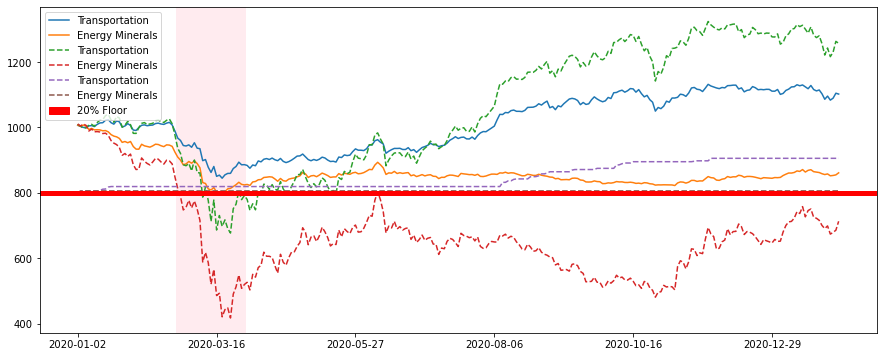

In [20]:
btr = run_cppi(r['2020-01-01':], s['2020-01-01':], m=3, drawdown=0.2)
ax = btr[0]["Wealth"].plot(figsize=(15,6))
btr[0]["Risky Wealth"].plot(ax=ax, style="--")
btr[0]['floor'].plot(ax=ax, style="--")
ax.axvspan(35.5, 60.5, facecolor ='pink', alpha = 0.3)
a = plt.axhline(1000*0.8, c='r', linewidth=5)
handles, labels = ax.get_legend_handles_labels()

# manually define a new patch 
patch = mpatches.Patch( color='red', label='20% Floor')

# handles is a list, so append manual patch
handles.append(patch) 
plt.legend(handles=handles, loc='upper left', fontsize=10)

<AxesSubplot:title={'center':'Allocations to the risky portfolios from the period of 03-01-2020 to 03-16-2020'}>

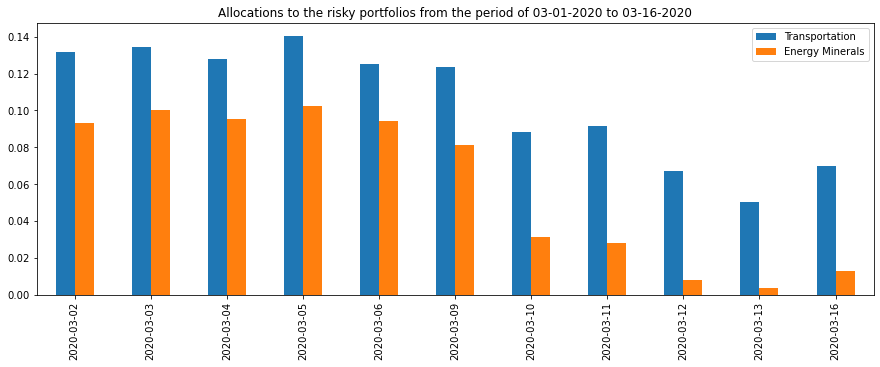

In [133]:
btr[0]['Risk Budget']['2020-03-01':'2020-03-16'].plot(kind='bar', figsize=(15,5), title='Allocations to the risky portfolios from the period of 03-01-2020 to 03-16-2020')

In [176]:
btr[0]['floor']

,Transportation,Energy Minerals
2020-01-02,950.000000,950.000000
2020-01-03,952.622164,952.739433
2020-01-06,952.933110,953.001855
2020-01-07,952.933110,953.567880
2020-01-08,952.933110,953.567880
...,...,...
2021-01-20,1014.874044,953.567880
2021-01-21,1016.566061,953.567880
2021-01-22,1016.566061,953.567880
2021-01-25,1016.566061,953.567880


In [136]:
(btr[0]['Wealth']['Energy Minerals'].nsmallest(1))/1000 - 1

2020-03-18   -0.20509
Name: Energy Minerals, dtype: float64

In [137]:
(btr[0]['Risky Wealth']['Energy Minerals'].nsmallest(1))/1000 - 1

2020-03-23   -0.582278
Name: Energy Minerals, dtype: float64

In [140]:
0.582278-0.20509

0.37718799999999997

In [181]:
btr[0]

{'Wealth':             Transportation  Energy Minerals
 2020-01-02     1006.423474      1006.917237
 2020-01-03     1003.397103      1003.684089
 2020-01-06     1000.007748      1007.209767
 2020-01-07      999.778236      1004.067796
 2020-01-08     1004.656849       993.609037
 ...                    ...              ...
 2021-01-20     1128.651704       870.768938
 2021-01-21     1116.398309       864.769293
 2021-01-22     1112.191094       863.417525
 2021-01-25     1114.982306       862.097257
 2021-01-26     1103.330681       858.477429
 
 [269 rows x 2 columns],
 'Risky Wealth':             Transportation  Energy Minerals
 2020-01-02     1009.679742      1010.502680
 2020-01-03     1003.651817      1004.126470
 2020-01-06      998.205510      1010.355667
 2020-01-07      998.586346      1005.836503
 2020-01-08     1007.564097       988.770507
 ...                    ...              ...
 2021-01-20     1308.049224       750.591473
 2021-01-21     1283.277892       725.268175
 2

In [21]:
summary_stats(btr[0]["Wealth"].pct_change().dropna())[["Annualized Return", "Annualized Vol", "Sharpe Ratio", "Max Drawdown"]]

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
Transportation,0.087463,0.134835,0.413803,-0.175079
Energy Minerals,-0.134504,0.103602,-1.541758,-0.210990


In [22]:
summary_stats(btr[0]["Risky Wealth"].pct_change().dropna())[["Annualized Return", "Annualized Vol", "Sharpe Ratio", "Max Drawdown"]]

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
Transportation,0.224433,0.362082,0.521387,-0.348918
Energy Minerals,-0.275422,0.579931,-0.511387,-0.587312
